# Neural Networks and Deep Learning Notes

Notes and equations from [neuralnetworksanddeeplearning.com](http://neuralnetworksanddeeplearning.com/)

# Chapter 4

## Overview

1. Convolutional neural networks.
2. Review of recent work with conv nets.
3. Recurrent and LSTM models.
4. Speculation on future work in neural networks.

## Introducing convolutional networks

- Networks with fully connected layers do not take into account the spatial structure of an image.
- "It treats input pixels which are far apart and close together on exactly the same footing."
- Three basic ideas: **local receptive fields**, **shared weights**, **pooling**.

### Local receptive fields

- Think of the MNIST inputs as a 28x28 square of neurons with values corresponding to the pixel intensities from the image.
- Connections to hidden layers are only made in small, localized regions of the input image.
- A hidden neuron's **local receptive field** is the field of inputs that are connected to it.

![](http://neuralnetworksanddeeplearning.com/images/tikz43.png)

- The LRF is slid across the image, connecting to a different neuron at each movement:

![](http://neuralnetworksanddeeplearning.com/images/tikz44.png)

![](http://neuralnetworksanddeeplearning.com/images/tikz45.png)

- The number of neurons in the hidden layer depends on the size of the receptive field. A 28x28 input with a 5x5 LRP would connect to a 24x24 hidden layer.
- The LRP stride length can vary - e.g. move 2 pixels for every connection.

### Shared weights (and biases)

- All of the neurons in the 24x24 layer use the same weights and bias.

$\begin{eqnarray} 
  \sigma\left(b + \sum_{l=0}^4 \sum_{m=0}^4  w_{l,m} a_{j+l, k+m} \right).
\tag{125}\end{eqnarray}$

- $w_{l,m}$ is a 5x5 array of shared weights, $b$ is a shared bias.
- All of the neurons in the first hidden layer detect exactly the same feature (e.g. an edge) across different locations of the image.
- This makes CNNs good for handling translated images - a picture of a cat shifted slightly is still a picture of a cat.
- To do image recognition, you need to be able to detect more than one type of feature. So a CNN combines multiple feature maps into each hidden layer:

![](http://neuralnetworksanddeeplearning.com/images/tikz46.png)

- Shared weights decrease the number of parameters in the network. A 24x24 feature map with 5x5 local receptive fields will have 25 weights + 1 bias = 26 parameters. Whereas a 30 neuron fully-connected layer will have 784x30 weights + 30 biases = 23,550 parameters.

### Pooling layers

- Pooling layers come after convolutional layers. They condense the multiple feature maps from a convolutional layer into a single simpler feature map.
- Each neuron in a pooling layer takes inputs from a specific section of the feature maps in the prior convolutional layer (e.g. a 2x2 section in the convolutional feature maps maps to a single neuron in the pooling layer).

![](http://neuralnetworksanddeeplearning.com/images/tikz47.png)

- Example: **max-pooling** layers take the max of each input segment.
- Intuition: the pooling layer asks whether a feature is anywhere in the image and throws away the positional information. Once a feature has been found, you only need its position relative other features, not its exact position.

![](http://neuralnetworksanddeeplearning.com/images/tikz48.png)

- Example: **L2 Pooling** layers take the square root of the sum of squares of each input segment.

### Putting it together

![](http://neuralnetworksanddeeplearning.com/images/tikz49.png)

1. 28 x 28 input neurons.
2. 3 feature maps, each taking 5 x 5 local receptive fields to form a 3 x 24 x 24 convolutional layer.
3. 3 max-pooling maps, each taking 2 x 2 local recpetive fields from the convolutional layer to form a 3 x 12 x 12 pooling layer.
4. Fully connected output layer.


### Backpropagation modifications

- The derivation of backpropagation requires some modifications due to the non-fully-connected layers.

## Convolutional neural networks in practice

In [1]:
from __future__ import print_function

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction=1.0
set_session(tf.Session(config=config))
print('done')

Using TensorFlow backend.


done


60000 training
10000 testing
Train on 60000 samples, validate on 10000 samples
Epoch 1/60
60000/60000 [==============================] - 12s - loss: 0.4111 - acc: 0.8804 - val_loss: 0.2364 - val_acc: 0.9320
Epoch 2/60
60000/60000 [==============================] - 11s - loss: 0.2086 - acc: 0.9387 - val_loss: 0.1740 - val_acc: 0.9486
Epoch 3/60
60000/60000 [==============================] - 11s - loss: 0.1566 - acc: 0.9544 - val_loss: 0.1391 - val_acc: 0.9596
Epoch 4/60
60000/60000 [==============================] - 11s - loss: 0.1254 - acc: 0.9630 - val_loss: 0.1219 - val_acc: 0.9639
Epoch 5/60
60000/60000 [==============================] - 11s - loss: 0.1057 - acc: 0.9692 - val_loss: 0.1039 - val_acc: 0.9682
Epoch 6/60
60000/60000 [==============================] - 11s - loss: 0.0904 - acc: 0.9739 - val_loss: 0.0997 - val_acc: 0.9704
Epoch 7/60
60000/60000 [==============================] - 11s - loss: 0.0789 - acc: 0.9774 - val_loss: 0.0971 - val_acc: 0.9699
Epoch 8/60
60000/60000 [=

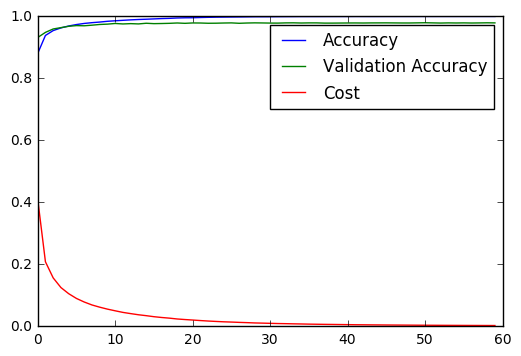

In [7]:
# Baseline: single hidden layer w/ 100 neurons, 60 epochs, learning rate 
# Accuracy 97.5.
# 0.1, batch size 10, no regularization
import matplotlib.pyplot as plt
import numpy as np
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.core import Dense, Dropout
from keras.optimizers import SGD
from keras.utils import np_utils

batch_size = 10
nb_train = 60000
nb_test = 10000
nb_pixel = 784
nb_classes = 10
nb_epochs = 60

(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Reshape and scale the images.
X_train = X_train.reshape(nb_train, nb_pixel).astype('float32') / 255
X_test = X_test.reshape(nb_test, nb_pixel).astype('float32') / 255

X_train = X_train[:nb_train]
y_train = y_train[:nb_train]

print(X_train.shape[0], 'training')
print(X_test.shape[0], 'testing')

# Convert class labels e.g. '3' to binary class matrices e.g. [0 0 0 1 0 ..].
y_train = np_utils.to_categorical(y_train, nb_classes)
y_test = np_utils.to_categorical(y_test, nb_classes)

model = Sequential()
model.add(Dense(100, input_shape=(nb_pixel,), activation='sigmoid', init='normal'))
model.add(Dense(10, input_shape=(nb_pixel,), activation='softmax', init='normal'))
model.compile(loss='categorical_crossentropy', optimizer=SGD(lr=0.1), metrics=['accuracy'])
result = model.fit(X_train, y_train, batch_size=batch_size, nb_epoch=nb_epochs,
                  verbose=1, validation_data=(X_test, y_test))
score = model.evaluatactivation='sigmoid'e(X_test, y_test, verbose=0)
print('holdout accuracy', score[1])

plt.title('Single fully-connected layer with 100 neurons.')
plt.plot(result.history['acc'], label='Accuracy')
plt.plot(result.history['val_acc'], label='Validation Accuracy')
plt.plot(result.history['loss'], label='Cost')
plt.legend()
plt.show()


X_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples
Train on 60000 samples, validate on 10000 samples
Epoch 1/60
60000/60000 [==============================] - 2s - loss: 1.4714 - acc: 0.5361 - val_loss: 0.5846 - val_acc: 0.8479
Epoch 2/60
60000/60000 [==============================] - 1s - loss: 0.4624 - acc: 0.8726 - val_loss: 0.3606 - val_acc: 0.8997
Epoch 3/60
60000/60000 [==============================] - 1s - loss: 0.3500 - acc: 0.8982 - val_loss: 0.2991 - val_acc: 0.9150
Epoch 4/60
60000/60000 [==============================] - 1s - loss: 0.3029 - acc: 0.9102 - val_loss: 0.2838 - val_acc: 0.9156
Epoch 5/60
60000/60000 [==============================] - 1s - loss: 0.2700 - acc: 0.9200 - val_loss: 0.2668 - val_acc: 0.9215
Epoch 6/60
60000/60000 [==============================] - 1s - loss: 0.2440 - acc: 0.9277 - val_loss: 0.2219 - val_acc: 0.9353
Epoch 7/60
60000/60000 [==============================] - 1s - loss: 0.2223 - acc: 0.9338 - val_loss: 0.2075 - val_

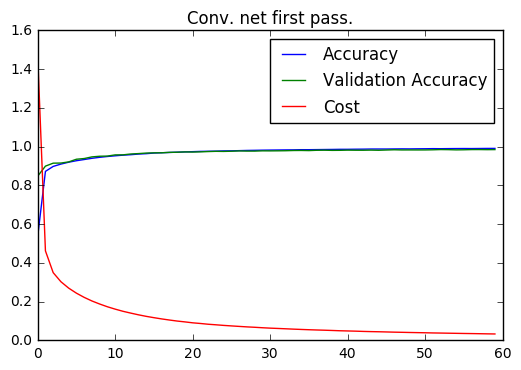

In [5]:
# Test a convolutional network to see if it gets better results.
# This improves accuracy to 98.5.
# Layer 1: 28 x 28 input.
# Layer 2: 20 x 24 x 24 convolutional layer with 5 x 5 local receptive fields.
# Layer 3: 20 x 12 x 12 pooling layer with 2 x 2 local receptive fields.
# Layer 4: 100 fully-connected sigmoid neurons.
# Layer 5: 10 fully-connected softmax neurons.
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(1337)

from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils
from keras.optimizers import SGD
from keras import backend as K

batch_size = 128
nb_classes = 10
nb_epoch = 60

# input image dimensions
img_rows, img_cols = 28, 28
# number of convolutional filters to use
nb_filters = 20
# convolution kernel size
kernel_size = (5, 5)
# size of pooling area for max pooling
pool_size = (2, 2)

# the data, shuffled and split between train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Different reshaping for Theano and Tensorflow.
X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

model = Sequential()

model.add(Convolution2D(nb_filters, kernel_size[0], kernel_size[1], input_shape=input_shape, activation='sigmoid'))
model.add(MaxPooling2D(pool_size=pool_size))
model.add(Flatten())
model.add(Dense(100, activation='sigmoid'))
model.add(Dense(nb_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=SGD(lr=0.1), metrics=['accuracy'])
result = model.fit(X_train, Y_train, batch_size=batch_size, nb_epoch=nb_epoch,
          verbose=1, validation_data=(X_test, Y_test))
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

plt.title('Conv. net first pass.')
plt.plot(result.history['acc'], label='Accuracy')
plt.plot(result.history['val_acc'], label='Validation Accuracy')
plt.plot(result.history['loss'], label='Cost')
plt.legend()
plt.show()

X_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples
Train on 60000 samples, validate on 10000 samples
Epoch 1/60
60000/60000 [==============================] - 2s - loss: 2.3000 - acc: 0.1197 - val_loss: 2.2736 - val_acc: 0.2447
Epoch 2/60
60000/60000 [==============================] - 2s - loss: 1.7354 - acc: 0.5129 - val_loss: 0.8204 - val_acc: 0.8192
Epoch 3/60
60000/60000 [==============================] - 2s - loss: 0.5791 - acc: 0.8508 - val_loss: 0.4190 - val_acc: 0.8874
Epoch 4/60
60000/60000 [==============================] - 2s - loss: 0.3710 - acc: 0.8968 - val_loss: 0.3048 - val_acc: 0.9139
Epoch 5/60
60000/60000 [==============================] - 2s - loss: 0.2898 - acc: 0.9168 - val_loss: 0.2472 - val_acc: 0.9279
Epoch 6/60
60000/60000 [==============================] - 2s - loss: 0.2429 - acc: 0.9297 - val_loss: 0.2120 - val_acc: 0.9382
Epoch 7/60
60000/60000 [==============================] - 2s - loss: 0.2102 - acc: 0.9383 - val_loss: 0.1874 - val_

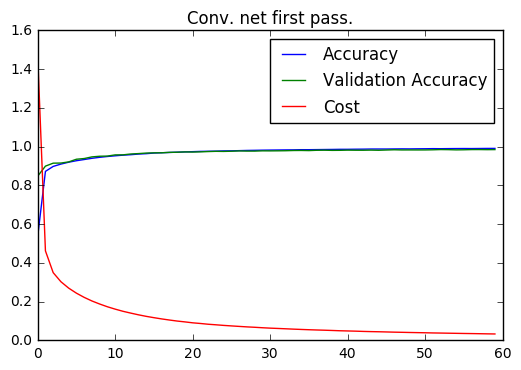

In [6]:
# Add a second convolution-pooling level. This improves accuracy to 98.67.
# The feature detectors in the second convolutional-pooling layer have 
# access to all the features from the previous layer, but only within 
# their particular local receptive field.
# Layer 1: 28 x 28 input.
# Layer 2: 20 x 24 x 24 convolutional layer with 5 x 5 local receptive fields.
# Layer 3: 20 x 12 x 12 pooling layer with 2 x 2 local receptive fields.
# Layer 4: 20 x 24 x 24 convolutional layer with 5 x 5 local receptive fields.
# Layer 5: 20 x 12 x 12 pooling layer with 2 x 2 local receptive fields.
# Layer 6: 100 fully-connected sigmoid neurons.
# Layer 7: 10 fully-connected softmax neurons.

from __future__ import print_function
import numpy as np
np.random.seed(1337)

from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils
from keras.optimizers import SGD
from keras import backend as K

batch_size = 128
nb_classes = 10
nb_epoch = 60

# input image dimensions
img_rows, img_cols = 28, 28
# number of convolutional filters to use
nb_filters = 20
# convolution kernel size
kernel_size = (5, 5)
# size of pooling area for max pooling
pool_size = (2, 2)

# the data, shuffled and split between train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Different reshaping for Theano and Tensorflow.
X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

model = Sequential()

model.add(Convolution2D(nb_filters, kernel_size[0], kernel_size[1], input_shape=input_shape, activation='sigmoid'))
model.add(MaxPooling2D(pool_size=pool_size))
model.add(Convolution2D(nb_filters, kernel_size[0], kernel_size[1], activation='sigmoid'))
model.add(MaxPooling2D(pool_size=pool_size))
model.add(Flatten())
model.add(Dense(100, activation='sigmoid'))
model.add(Dense(nb_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=SGD(lr=0.1), metrics=['accuracy'])
model.fit(X_train, Y_train, batch_size=batch_size, nb_epoch=nb_epoch,
          verbose=1, validation_data=(X_test, Y_test))
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

plt.title('Conv. net first pass.')
plt.plot(result.history['acc'], label='Accuracy')
plt.plot(result.history['val_acc'], label='Validation Accuracy')
plt.plot(result.history['loss'], label='Cost')
plt.legend()
plt.show()

X_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples
Train on 60000 samples, validate on 10000 samples
Epoch 1/60
60000/60000 [==============================] - 2s - loss: 0.3037 - acc: 0.9199 - val_loss: 0.1231 - val_acc: 0.9644
Epoch 2/60
60000/60000 [==============================] - 2s - loss: 0.1031 - acc: 0.9703 - val_loss: 0.0778 - val_acc: 0.9773
Epoch 3/60
60000/60000 [==============================] - 2s - loss: 0.0738 - acc: 0.9783 - val_loss: 0.0610 - val_acc: 0.9823
Epoch 4/60
60000/60000 [==============================] - 2s - loss: 0.0589 - acc: 0.9829 - val_loss: 0.0590 - val_acc: 0.9818
Epoch 5/60
60000/60000 [==============================] - 2s - loss: 0.0498 - acc: 0.9855 - val_loss: 0.0450 - val_acc: 0.9858
Epoch 6/60
60000/60000 [==============================] - 2s - loss: 0.0438 - acc: 0.9877 - val_loss: 0.0410 - val_acc: 0.9871
Epoch 7/60
60000/60000 [==============================] - 2s - loss: 0.0386 - acc: 0.9887 - val_loss: 0.0382 - val_

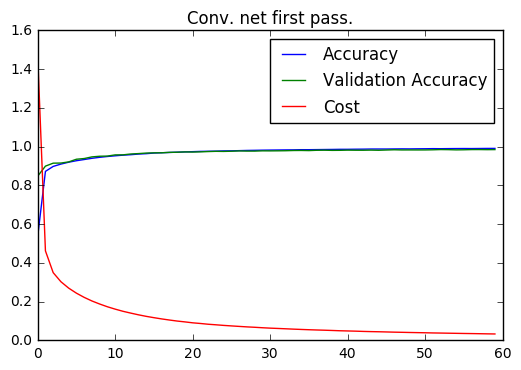

In [7]:
# Same architecture, but switch to the tanh function.
# Nielsen claims that the tanh trains a little faster
# but ends up at the same accuracy.
# In my case it's tough to tell if it learns more quickly because
# the sigmoid neurons learned quickly anyway. It does achieve
# New high score! accuracy 99.18.
import numpy as np
np.random.seed(1337)

from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils
from keras.optimizers import SGD
from keras import backend as K

batch_size = 128
nb_classes = 10
nb_epoch = 60

# input image dimensions
img_rows, img_cols = 28, 28
# number of convolutional filters to use
nb_filters = 20
# convolution kernel size
kernel_size = (5, 5)
# size of pooling area for max pooling
pool_size = (2, 2)

# the data, shuffled and split between train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Different reshaping for Theano and Tensorflow.
X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

model = Sequential()

model.add(Convolution2D(nb_filters, kernel_size[0], kernel_size[1], input_shape=input_shape, activation='tanh'))
model.add(MaxPooling2D(pool_size=pool_size))
model.add(Convolution2D(nb_filters, kernel_size[0], kernel_size[1], activation='tanh'))
model.add(MaxPooling2D(pool_size=pool_size))
model.add(Flatten())
model.add(Dense(100, activation='tanh'))
model.add(Dense(nb_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=SGD(lr=0.1), metrics=['accuracy'])
model.fit(X_train, Y_train, batch_size=batch_size, nb_epoch=nb_epoch,
          verbose=1, validation_data=(X_test, Y_test))
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

plt.title('Conv. net first pass.')
plt.plot(result.history['acc'], label='Accuracy')
plt.plot(result.history['val_acc'], label='Validation Accuracy')
plt.plot(result.history['loss'], label='Cost')
plt.legend()
plt.show()

X_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples
Train on 60000 samples, validate on 10000 samples
Epoch 1/60
60000/60000 [==============================] - 2s - loss: 0.8318 - acc: 0.9008 - val_loss: 0.5496 - val_acc: 0.9505
Epoch 2/60
60000/60000 [==============================] - 2s - loss: 0.5220 - acc: 0.9542 - val_loss: 0.4797 - val_acc: 0.9630
Epoch 3/60
60000/60000 [==============================] - 2s - loss: 0.4759 - acc: 0.9624 - val_loss: 0.4540 - val_acc: 0.9679
Epoch 4/60
60000/60000 [==============================] - 2s - loss: 0.4507 - acc: 0.9674 - val_loss: 0.4380 - val_acc: 0.9699
Epoch 5/60
60000/60000 [==============================] - 2s - loss: 0.4342 - acc: 0.9705 - val_loss: 0.4207 - val_acc: 0.9725
Epoch 6/60
60000/60000 [==============================] - 2s - loss: 0.4226 - acc: 0.9725 - val_loss: 0.4175 - val_acc: 0.9735
Epoch 7/60
60000/60000 [==============================] - 2s - loss: 0.4133 - acc: 0.9740 - val_loss: 0.4042 - val_

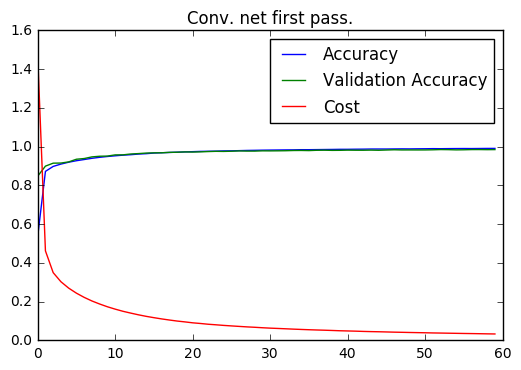

In [9]:
# Switch to relu (rectified linear unit) activations.
# Add L2 regularization with lambda = 0.1.
# This actually gets slightly worse, accuracy 98.93
import numpy as np
np.random.seed(1337)

from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils
from keras.optimizers import SGD
from keras.regularizers import l2
from keras import backend as K


batch_size = 128
nb_classes = 10
nb_epoch = 60

# input image dimensions
img_rows, img_cols = 28, 28
# number of convolutional filters to use
nb_filters = 20
# convolution kernel size
kernel_size = (5, 5)
# size of pooling area for max pooling
pool_size = (2, 2)

# the data, shuffled and split between train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Different reshaping for Theano and Tensorflow.
X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

model = Sequential()

model.add(Convolution2D(nb_filters, kernel_size[0], kernel_size[1], input_shape=input_shape, activation='relu'))
model.add(MaxPooling2D(pool_size=pool_size))
model.add(Convolution2D(nb_filters, kernel_size[0], kernel_size[1], activation='relu'))
model.add(MaxPooling2D(pool_size=pool_size))
model.add(Flatten())
model.add(Dense(100, activation='tanh'))
model.add(Dense(nb_classes, activation='softmax', W_regularizer=l2(l=0.1)))

model.compile(loss='categorical_crossentropy', optimizer=SGD(lr=0.1), metrics=['accuracy'])
model.fit(X_train, Y_train, batch_size=batch_size, nb_epoch=nb_epoch,
          verbose=1, validation_data=(X_test, Y_test))
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

plt.title('Conv. net first pass.')
plt.plot(result.history['acc'], label='Accuracy')
plt.plot(result.history['val_acc'], label='Validation Accuracy')
plt.plot(result.history['loss'], label='Cost')
plt.legend()
plt.show()

X_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples
Train on 60000 samples, validate on 10000 samples
Epoch 1/60
60000/60000 [==============================] - 2s - loss: 0.3681 - acc: 0.8847 - val_loss: 0.0951 - val_acc: 0.9705
Epoch 2/60
60000/60000 [==============================] - 2s - loss: 0.1232 - acc: 0.9631 - val_loss: 0.0609 - val_acc: 0.9806
Epoch 3/60
60000/60000 [==============================] - 2s - loss: 0.0923 - acc: 0.9734 - val_loss: 0.0493 - val_acc: 0.9836
Epoch 4/60
60000/60000 [==============================] - 2s - loss: 0.0754 - acc: 0.9770 - val_loss: 0.0501 - val_acc: 0.9840
Epoch 5/60
60000/60000 [==============================] - 2s - loss: 0.0654 - acc: 0.9802 - val_loss: 0.0434 - val_acc: 0.9864
Epoch 6/60
60000/60000 [==============================] - 2s - loss: 0.0604 - acc: 0.9814 - val_loss: 0.0539 - val_acc: 0.9825
Epoch 7/60
60000/60000 [==============================] - 2s - loss: 0.0537 - acc: 0.9833 - val_loss: 0.0335 - val_

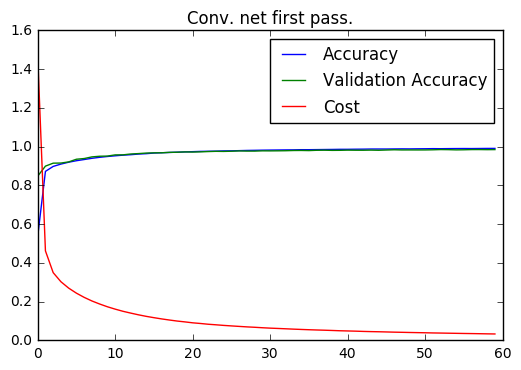

In [11]:
# Add a dropout layer after the fully connected layer.
# New high score! accuracy 99.31.
import numpy as np
np.random.seed(1337)

from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils
from keras.optimizers import SGD
from keras.regularizers import l2
from keras import backend as K


batch_size = 128
nb_classes = 10
nb_epoch = 60

# input image dimensions
img_rows, img_cols = 28, 28
# number of convolutional filters to use
nb_filters = 20
# convolution kernel size
kernel_size = (5, 5)
# size of pooling area for max pooling
pool_size = (2, 2)

# the data, shuffled and split between train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Different reshaping for Theano and Tensorflow.
X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

model = Sequential()

model.add(Convolution2D(nb_filters, kernel_size[0], kernel_size[1], input_shape=input_shape, activation='relu'))
model.add(MaxPooling2D(pool_size=pool_size))
model.add(Convolution2D(nb_filters, kernel_size[0], kernel_size[1], activation='relu'))
model.add(MaxPooling2D(pool_size=pool_size))
model.add(Flatten())
model.add(Dense(100, activation='tanh'))
model.add(Dropout(p=0.5))
model.add(Dense(nb_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=SGD(lr=0.1), metrics=['accuracy'])
model.fit(X_train, Y_train, batch_size=batch_size, nb_epoch=nb_epoch,
          verbose=1, validation_data=(X_test, Y_test))
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

plt.title('Conv. net first pass.')
plt.plot(result.history['acc'], label='Accuracy')
plt.plot(result.history['val_acc'], label='Validation Accuracy')
plt.plot(result.history['loss'], label='Cost')
plt.legend()
plt.show()

In [13]:
# Train an ensemble of networks and use them in a voting scheme.
# This requires some modification to the evaluation.
# New high score! accuracy 99.41.
import numpy as np
np.random.seed(1337)

from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils
from keras.optimizers import SGD
from keras.regularizers import l2
from keras import backend as K

batch_size = 128
nb_classes = 10
nb_epoch = 30

# input image dimensions
img_rows, img_cols = 28, 28
# number of convolutional filters to use
nb_filters = 20
# convolution kernel size
kernel_size = (5, 5)
# size of pooling area for max pooling
pool_size = (2, 2)

# the data, shuffled and split between train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Different reshaping for Theano and Tensorflow.
X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

ensemble = []

for i in range(10):
    model = Sequential()
    model.add(Convolution2D(nb_filters, kernel_size[0], kernel_size[1], input_shape=input_shape, activation='relu'))
    model.add(MaxPooling2D(pool_size=pool_size))
    model.add(Convolution2D(nb_filters, kernel_size[0], kernel_size[1], activation='relu'))
    model.add(MaxPooling2D(pool_size=pool_size))
    model.add(Flatten())
    model.add(Dense(100, activation='tanh'))
    model.add(Dropout(p=0.5))
    model.add(Dense(nb_classes, activation='softmax'))
# Evaluate ensemble accuracy.
ensemble_predictions = [m.predict(X_test) for m in ensemble]
    model.compile(loss='categorical_crossentropy', optimizer=SGD(lr=0.1), metrics=['accuracy'])
    model.fit(X_train, Y_train, batch_size=batch_size, nb_epoch=nb_epoch,
              verbose=0, validation_data=(X_test, Y_test))
    
    score = model.evaluate(X_test, Y_test, verbose=0)
    print('Test score', i, score[0])
    print('Test accuracy', i, score[1])
    
    ensemble.append(model)

X_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples
Test score 0 0.023918196626
Test accuracy 0 0.992
Test score 1 0.0241308374883
Test accuracy 1 0.9916
Test score 2 0.0260990836768
Test accuracy 2 0.9917
Test score 3 0.0236094436534
Test accuracy 3 0.9933
Test score 4 0.0247462581147
Test accuracy 4 0.9929
Test score 5 0.0234907348481
Test accuracy 5 0.9929
Test score 6 0.020672258717
Test accuracy 6 0.993
Test score 7 0.0227052558399
Test accuracy 7 0.9931
Test score 8 0.0238568537968
Test accuracy 8 0.9927
Test score 9 0.0217398692304
Test accuracy 9 0.9927


In [29]:
# Evaluate ensemble accuracy.
# Somewhat hacked together solution.
ensemble_predictions = [m.predict(X_test) for m in ensemble]

results = []
for i in range(10000):
    votes = np.zeros(10)
    for j in range(10):
        votes += ensemble_predictions[j][i]
    result = np.zeros(10)
    result[np.argmax(votes)] = 1
    results.append(list(result))
results = np.array(results)

nb_wrong = sum([max(a - b) for (a,b) in zip(Y_test, results)])
print('accuracy =', (10000 - nb_wrong) / 10000)

accuracy = 0.9941


## Discussion of other types of neural networks

### Recurrent neural networks

- Maintain state over time.
- Suffer from fading gradient problems in training.
- Introduction of LSTM units improved this.

### Deep belief nets

- Generative model.
- Useful for unsupervised learning.
- Currently not the most popular but still a useful model.